The goal of this notebook is to verify our implementation of the DMDc algorithm

In [643]:
# Imports
#!/usr/bin/env python
# -*- coding: utf-8 -*-
import numpy as np
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import csr_matrix
from sklearn.utils.extmath import randomized_svd
 
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.animation import FuncAnimation
from dotenv import dotenv_values 
from moviepy.editor import VideoClip
from moviepy.video.io.bindings import mplfig_to_npimage
import scipy.io
from scipy.signal import cont2discrete
import pyvista as pv
import h5py
import mat73
import dask.array as da
from dask.distributed import Client, LocalCluster
import opinf
config = dotenv_values(".env")
from util import *
from scipy import signal

In [644]:
# # Setup Dask client
# # cluster = LocalCluster() # Launches a scheduler and workers locally
# # client = Client(cluster) # Connect to distributed cluster and override default
# client = Client('tcp://127.0.0.1:8786')
# client.cluster

In [645]:
# Hyperparameters for simulation
n = 100 # dimension of full order state
l = 6 # dimension of input vector
m = 40 # dimension of output vector

n_timesteps = 5000 # number of timesteps to simulate
dt = 0.01 # timestep size




In [646]:
# Make random linear system matrices with some sparsity where entries are drawn from normal distribution
A = np.random.rand(n,n) 
# A[np.abs(A<0.4)] = 0
A = A - np.diag(np.sum(A, axis=0))
B = np.random.rand(n, l)
# Make C a pass-through matrix
# C=np.eye(m,n)

C = np.random.rand(m, n)
D = np.zeros((m, l))



In [647]:
# Make discrete time linear system
dMats = signal.cont2discrete((A, B, C, D), dt=dt)
# sys = signal.dlti(dMats[0], dMats[1], dMats[2], dMats[3], dt=dt)
A_d = dMats[0] # np.array([0.5]) 
B_d = dMats[1] # np.array([1]) 
C_d = dMats[2] # np.array([1]) 
D_d = dMats[3] # np.array([0]) 

In [648]:
# Set initial condition and input
x0 = np.zeros((n, 1))
u = (np.random.rand(l, n_timesteps)-0.5)
# u = np.cumsum(u, axis=1)
#np.sin(np.linspace(0, 10, n_timesteps))

# Set amount of gaussian noise to add to input
eps_input = 0.0005
eps_output = 0

In [649]:
C_d.shape

(2, 10)

In [650]:
# Simulate discrete time linear system
# Initialize array to hold state data and output data
X_fom = np.zeros((n, n_timesteps))
X_fom[:, [0]] = x0
Y_fom = np.zeros((m, n_timesteps))
Y_fom[:, [0]] = np.dot(C_d, x0)

In [651]:
# Simulate system
for i in range(1, n_timesteps):
    X_fom[:, i] = np.dot(A_d, X_fom[:, i-1]) + np.dot(B_d, u[:,i-1]) + np.random.normal(0, eps_input, (n, 1))[:,0]
    Y_fom[:, i] = np.dot(C_d, X_fom[:, i]) #+ np.dot(D_d, u[:,i-1]) + np.random.normal(0, eps_output, (m, 1))[:,0]

In [652]:
# Make Koopman Data matrices with time delay embedding of N_delay timesteps
N_delay = 3
Z_fom = np.zeros((m*(N_delay+1), n_timesteps))
for i in range(0, n_timesteps):
    for j in range(N_delay+1):
        # fill 0s if not enough data
        if i-j< 0:
            Z_fom[j*m:(j+1)*m, i] = 0
        else:
            Z_fom[j*m:(j+1)*m, i] = Y_fom[:, i-j]

In [653]:
# Make DMDc data matrices
X_train = da.from_array(Z_fom[:, :-1], chunks=(m*(N_delay+1), 4000))
Xprime_train = da.from_array(Z_fom[:, 1:], chunks=(m*(N_delay+1), 4000))
Upsilon_train = da.from_array(u[:, :-1], chunks=(l, 4000))
Y_train = da.from_array(Y_fom[:, :-1], chunks=(m, 4000))

In [654]:
Upsilon_train.shape

(2, 4999)

In [655]:
# Compute DMDc ROM
p_dmd = int(m*(N_delay+1))# dimension of reduced input space
n_ROM = p_dmd # dimension of reduced order state
# Form snapshot matrices for DMDc
Omega = da.concatenate([X_train,Upsilon_train],axis=0)
Omega = Omega.rechunk((Omega.shape[0],4000))
print("got here 4")
# Decompose snapshot matrix using truncated SVD
# r_dmd = n_ROM
print("got here 5")
U_tilde,Sigma_tilde,Vh_tilde = da.linalg.svd(Omega)
# Vh_tilde = da.conj(da.transpose(V_tilde))
Sigma_tilde = da.diag(Sigma_tilde)
# U_hat, Sigma_hat, V_hat = da.linalg.svd_compressed(Xprime_train, r_dmd)
# Sigma_hat = da.diag(Sigma_hat)
print("got here 6")
# Compute system state evolution matrices
# U_tilde_1 = U_tilde[0:m*N_delay,:]
# U_tilde_2 = U_tilde[m*N_delay:,:]
stateMats = Xprime_train@(Vh_tilde.conj().T)@(da.linalg.inv(Sigma_tilde))@(U_tilde.conj().T)
# A_dmdc = Xprime_train@(Vh_tilde.conj().T)@(da.linalg.inv(Sigma_tilde))@(U_tilde_1.conj().T)
# B_dmdc = Xprime_train@(Vh_tilde.conj().T)@(da.linalg.inv(Sigma_tilde))@(U_tilde_2.conj().T)
A_dmdc = stateMats[:,0:n_ROM]
B_dmdc = stateMats[:,n_ROM:]

# C matrix just extracts the first m states
C_dmdc = da.concatenate([da.eye(m),da.zeros((m,m*N_delay))],axis=1)

# A_dmdc = (U_hat.conj().T)@Xprime_train@(Vh_tilde.conj().T)@(da.linalg.inv(Sigma_tilde))@(U_tilde_1.conj().T)@U_hat
# B_dmdc = (U_hat.conj().T)@Xprime_train@(Vh_tilde.conj().T)@(da.linalg.inv(Sigma_tilde))@(U_tilde_2.conj().T)

# print("got here 7")

# # Solve for system output matrix from full order system
# ys = Y_train[:,0:250]

# compute approximate pseudoinverse of data matrix using SVD
# X_train = X_train.rechunk((2000,X_train.shape[1])) # Rechunk along one dimension
# U_X_train, S_X_train, Vh_X_train = da.linalg.svd(X_train[:,0:250])
# X_PI = da.matmul(da.transpose(Vh_X_train),da.matmul(da.diag(da.reciprocal(S_X_train)),da.transpose(U_X_train)))

# print("got here 8")

# # # X_PI = np.linalg.pinv(X_train[:,0:10])
# C_dmdc = ys@X_PI
# C_dmdc = C_dmdc@U_hat
# print("got here 9")
# # Execute computations for dmdc system matrices
# print("Computing DMDc system matrices for n_ROM = ", n_ROM)
# A_dmdc, B_dmdc, C_dmdc,U_hat = da.compute(A_dmdc, B_dmdc, C_dmdc,U_hat)
A_dmdc, B_dmdc, C_dmdc = da.compute(A_dmdc, B_dmdc, C_dmdc)
# # A_dmdc, B_dmdc = da.compute(A_dmdc, B_dmdc)
# # A_dmdc = A_dmdc.compute()
# print("got here 10")
# # B_dmdc = B_dmdc.compute()
# # print("got here 11")
# # C_dmdc = C_dmdc.compute()
# # print("got here 12")
# # U_hat = U_hat.compute()
# # print("got here 13")
# basis_dmdc = U_hat[:,0:n_ROM]



got here 4
got here 5
got here 6


In [656]:
# Compute svd matrices
U_tilde,Sigma_tilde,Vh_tilde = da.linalg.svd(Omega)
U_tilde,Sigma_tilde,Vh_tilde = da.compute(U_tilde,Sigma_tilde,Vh_tilde)

In [657]:
# Compute pseudoinverse 
testPI = np.matmul(np.transpose(Vh_tilde),np.matmul(np.diag(np.reciprocal(Sigma_tilde)),np.transpose(U_tilde)))


In [658]:
# Simulate koopman dynamics from the N_delay-th timestep
X_koop = np.zeros((n_ROM, n_timesteps))
X_koop[:, [0]] = np.zeros((n_ROM, 1))
Y_koop = np.zeros((m, n_timesteps))
for i in range(1, n_timesteps):
    X_koop[:, [i]] = A_dmdc@X_koop[:, [i-1]] + B_dmdc@u[:, [i-1]]
    Y_koop[:, [i]] = C_dmdc@X_koop[:, [i]]

Text(0.5, 1.0, 'Koopman Model')

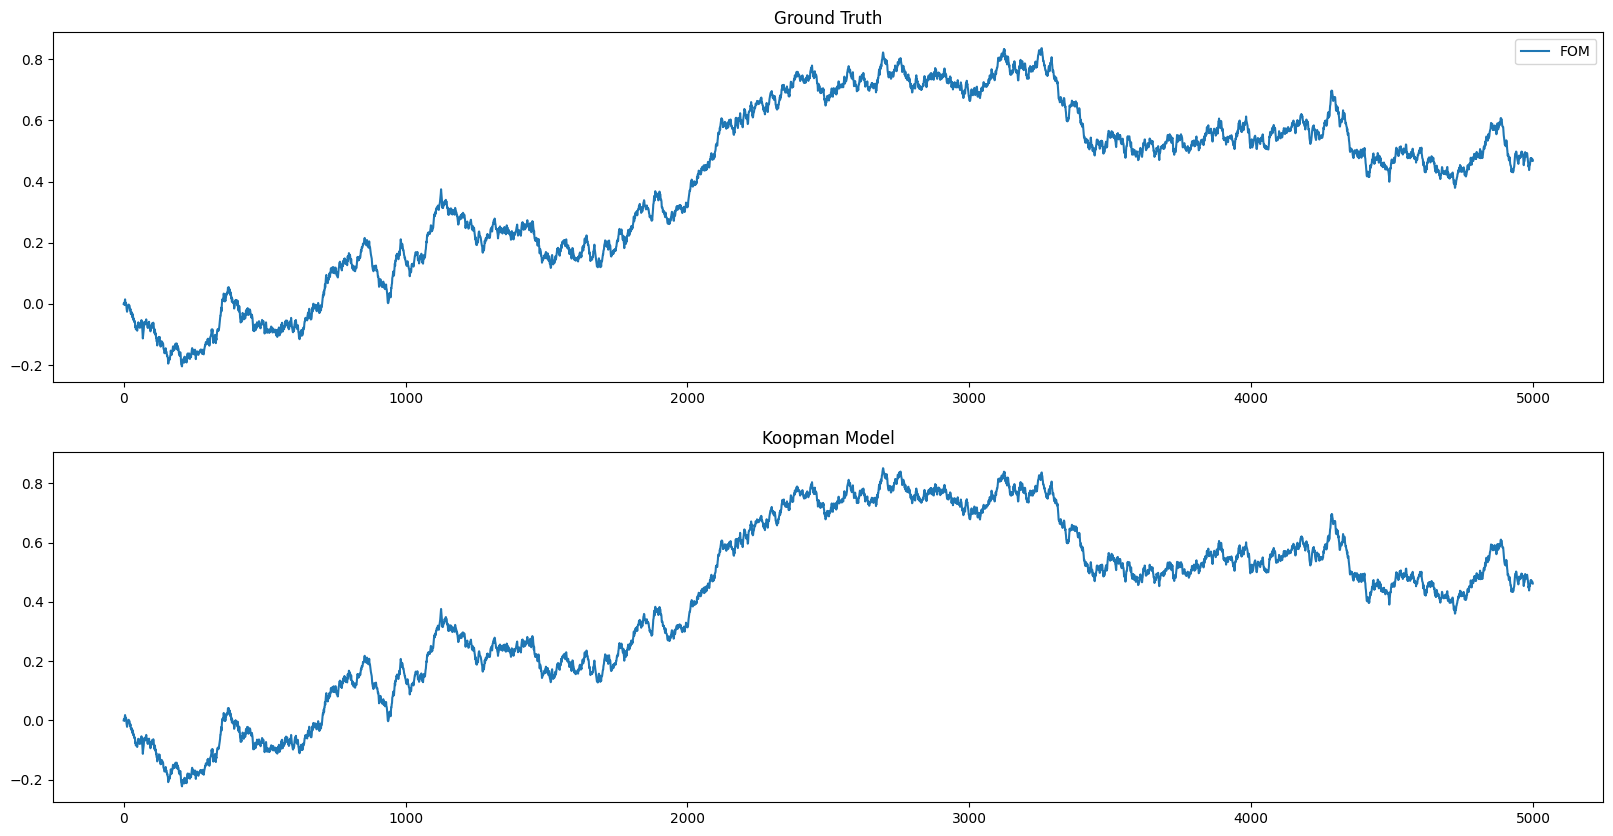

In [659]:
# Plot results against ground truth on different subplots ignoring the first N_delay timesteps
index = 0 
plt.figure(figsize=(20,10))
plt.subplot(2,1,1)
plt.plot(Y_fom[index, :], label='FOM')
plt.title('Ground Truth')
plt.legend()
plt.subplot(2,1,2)
plt.plot(Y_koop[index, :], label='Koopman')
plt.title('Koopman Model')

In [660]:
Y_koop.shape

(2, 5000)

In [661]:
# Compute relative errors between FOM and DMDc states and outputs
# X_err = np.linalg.norm(X_fom - X_dmdc_full)/np.linalg.norm(X_fom)
Y_err = np.linalg.norm(Y_fom - Y_koop)/np.linalg.norm(Y_fom)
# print("X error: ", X_err)
print("Y error: ", Y_err)

Y error:  0.02962022953189829


In [662]:
# # Print off original and computed system matrices
# print("Original: A = ", A_d, ", B = ", B_d, ", C = ", C_d)
# print("DMDc: A = ", A_dmdc, ", B = ", B_dmdc, ", C = ", C_dmdc)